In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython
from IPython.display import Audio, Image

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


Sound is transmitted through the air as air pressure oscillations. In essence, sound is simply vibrating air.

The change in air pressure measured over a certain time is graphically represented by a pressure-time plot, or simply waveform.

Any sound can be described as a combination of sine waves, or, in other words, any sounds can be deconstructed into its sinusoidal components.

An audio signal is a representation of sound that represents the fluctuation in air pressure caused by the vibration as a function of time.

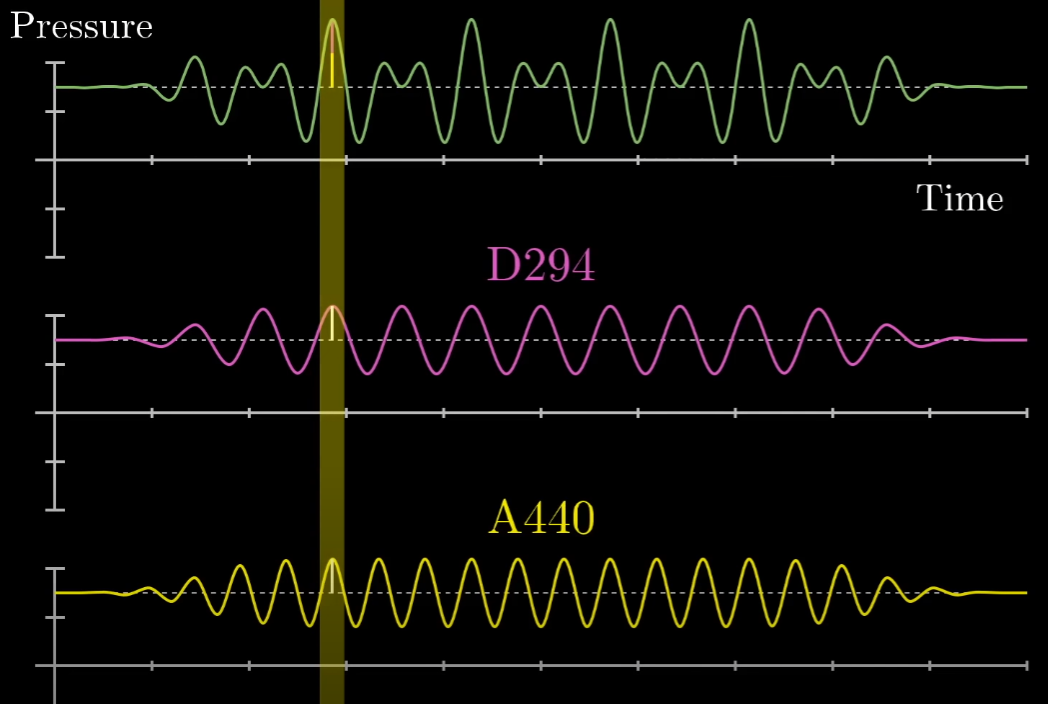

In [2]:
Image("Fourier.png", width=600)

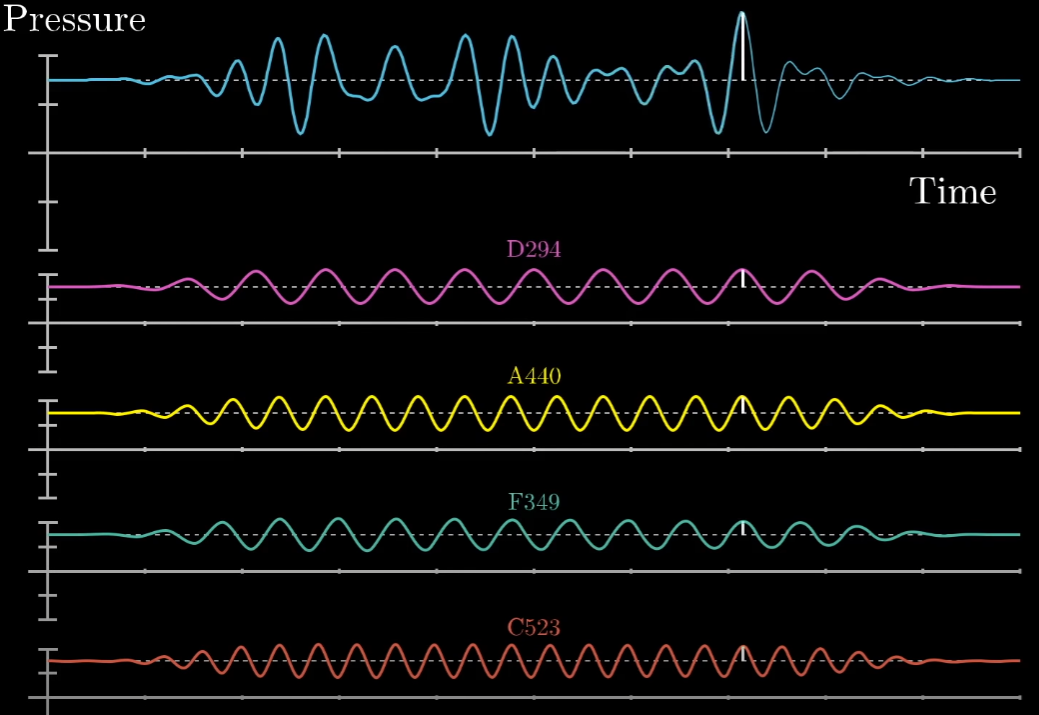

In [3]:
Image("Fourier2.png", width=600)

## Frequency (Hz)

Frequency describes the differences of wave lengths of those sinusoidal curves.
Frequency has high and low pitches.

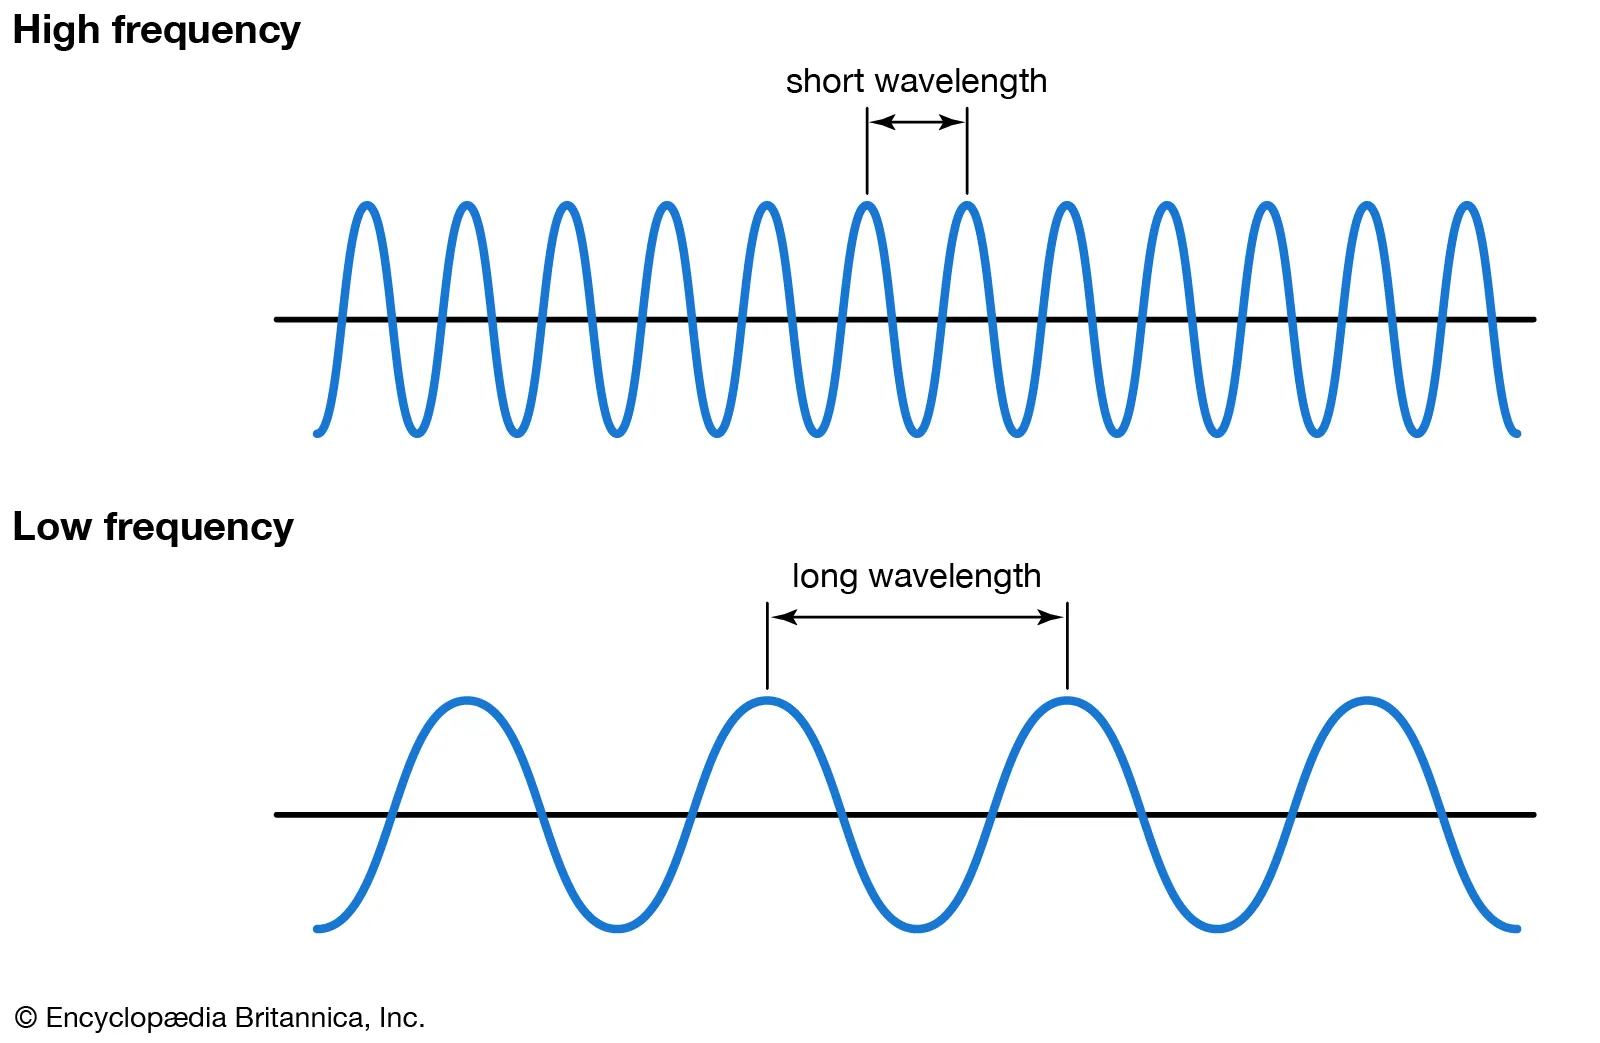

In [4]:
Image(filename='Frequency.png', width=600) 

## Intensity (db / power)

Intensity describes the amplitude (height) of the wave.

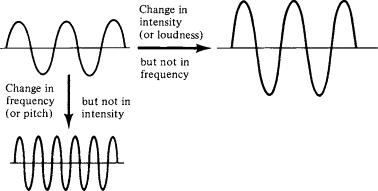

In [5]:
Image(filename='Intensity.gif', width=600) 

## Sample Rate

Sample rate is specific to how the computer reads in the audio file.

Think of it as the "resolution" of the audio.

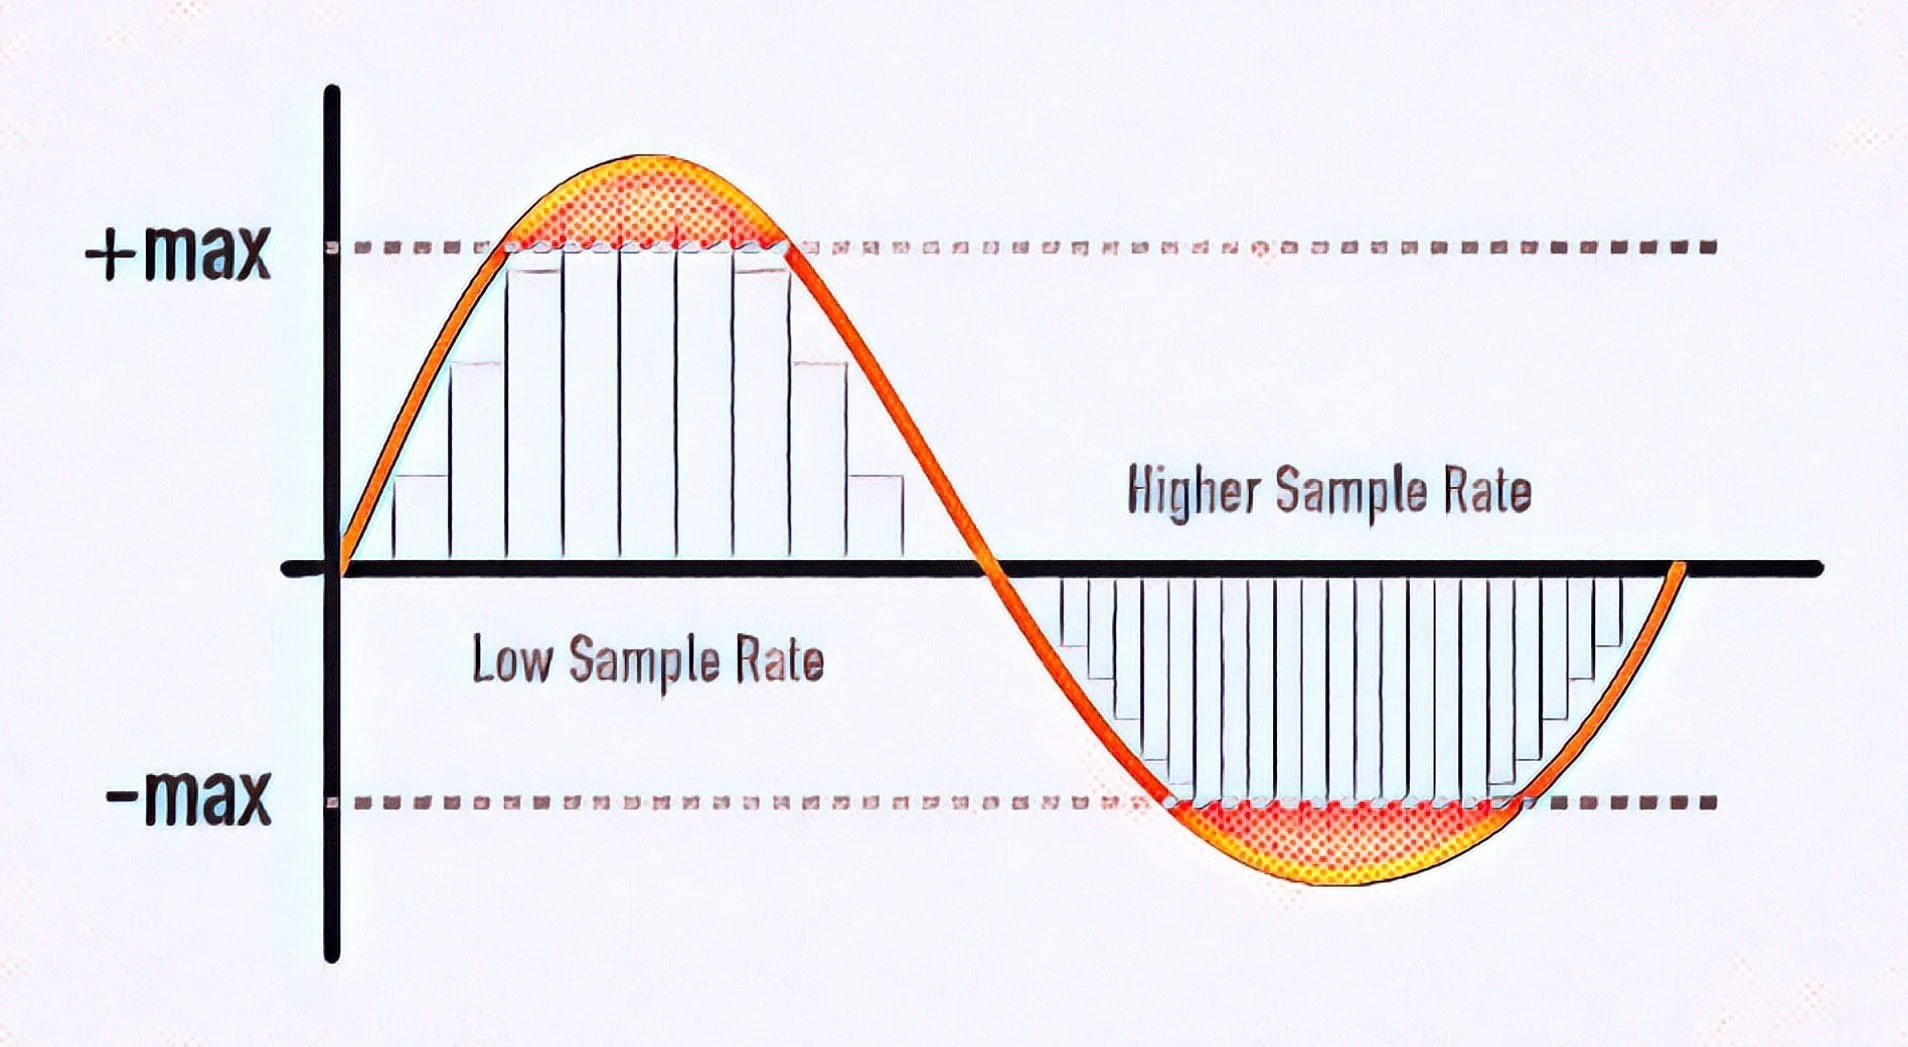

In [6]:
Image('SampleRate.png', width=600)

## Spectrograms and  Waveplots

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.
It is a way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. 

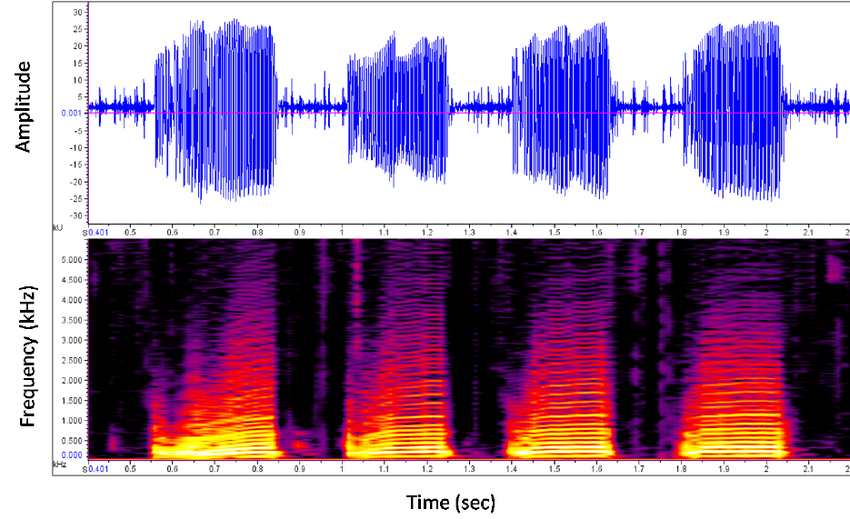

In [7]:
Image(filename='Spectrogram.png', width=600) 

## Lets take a look at the spectrogram and waveplot of a fearful voice:

We've already seen waveplots, they are just a graphical representation of the change in air pressure at a certain time.

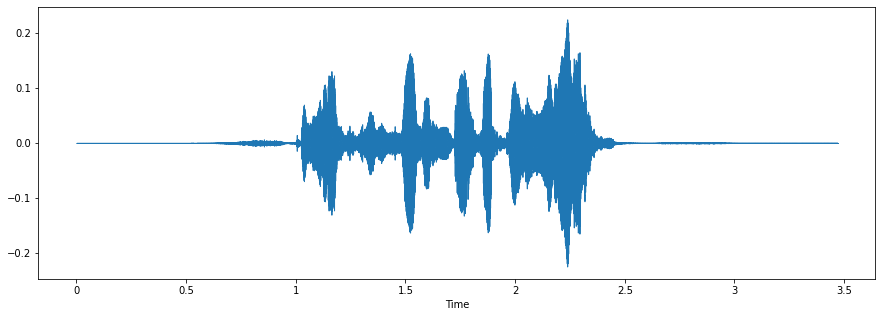

In [8]:
# Pick a fearful track
fname = "03-01-06-02-02-02-14.mp3"
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))

librosa.display.waveshow(data, sr=sampling_rate)

# Play the audio
Audio(fname)


## Spectogram

The frequency spectrum of a signal is the range of frequencies contained by a signal.

And the spectogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

One axis represents time, and the other axis represents frequency; a third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity or color of each point in the image.

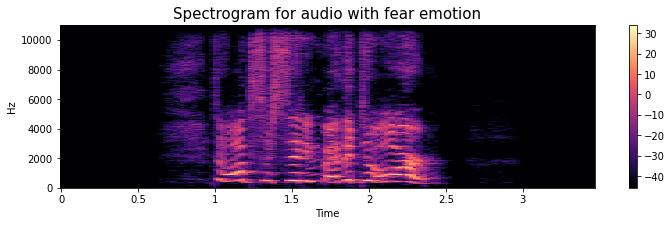

In [9]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

create_spectrogram(data, sampling_rate, 'fear')


Let's now load the full dataset and take a look at the distribution of the categories.

In [10]:
Ravdess = 'input/audio_speech_actors_01-24/'
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  input/audio_speech_actors_01-24/Actor_01/03-01...
1  neutral  input/audio_speech_actors_01-24/Actor_01/03-01...
2  neutral  input/audio_speech_actors_01-24/Actor_01/03-01...
3  neutral  input/audio_speech_actors_01-24/Actor_01/03-01...
4     calm  input/audio_speech_actors_01-24/Actor_01/03-01...

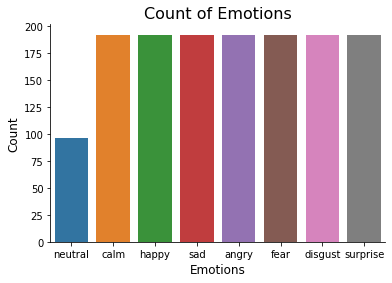

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Ok, we're ready to start pre-processing the data. 
First let's do some data augmentation.

## Data Augmentation

Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

The objective is to make our model invariant to those perturbations and enhace its ability to generalize.

In order to this to work adding the perturbations must conserve the same label as the original training sample.

In images data augmention can be performed by shifting the image, zooming, rotating, etc.

For audio augmentation, we can add noise, stretch it, shift it, and change its pitch.

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-10, high = 10)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
data, sample_rate = librosa.load(fname)

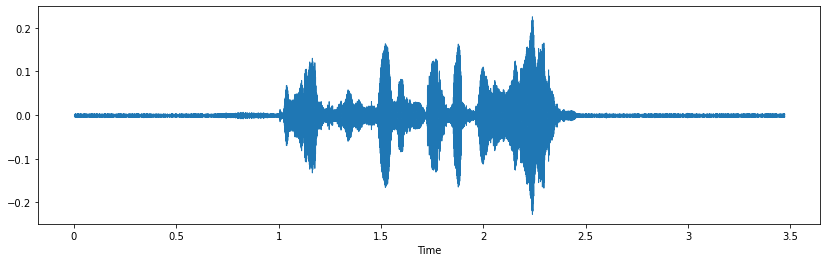

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

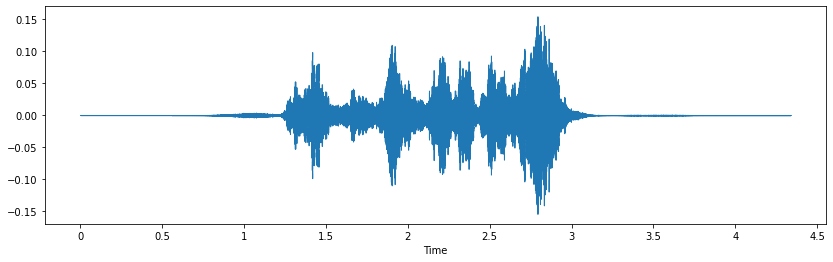

In [14]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

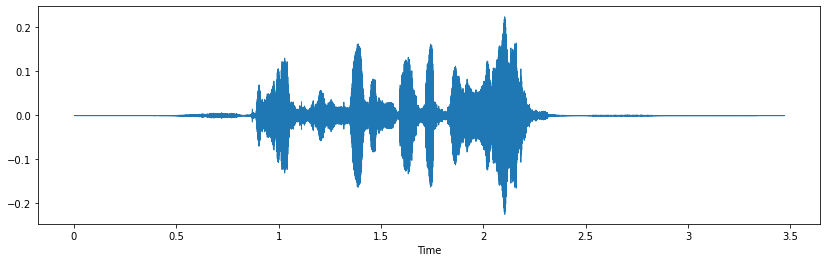

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

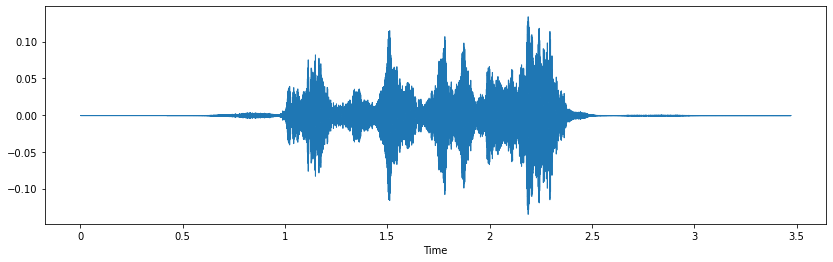

In [16]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

All right, now that we're done with that, we can try to extract some features from the data.

## Feature Extraction

Extraction of features is a very important part in analyzing and finding relations between different things.

It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency, as we've seen represented by spectograms.

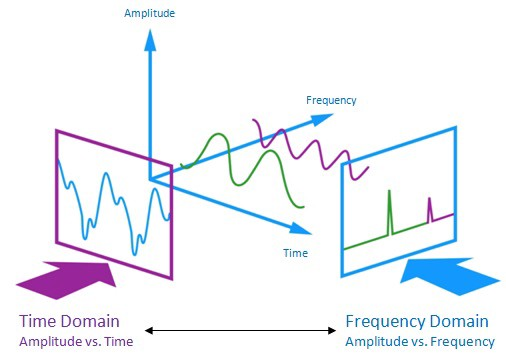

In [17]:
Image("3d.jpeg", width=600)

One can perform several transformations on the audio data to extract valuable features out of it, such as:

Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.

Energy : The sum of squares of the signal values, normalized by the respective frame length.

Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.

Spectral Centroid : The center of gravity of the spectrum.

Spectral Spread : The second central moment of the spectrum.

Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.

Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.

Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).

Chroma Deviation : The standard deviation of the 12 chroma coefficients.

## MFCC

In sound processing, the mel-frequency cepstrum is a representation of the short-term power spectrum of a sound.

They are a feature widely used in automatic speech and speaker recognition, as they were introduced by Davis and Mermelstein in the 1980's, and have been state-of-the-art ever since.

Speech is dictated by the way in which we use our oral anatomy to create each sound. Therefore, one way to uniquely identify a sound (independent of the speaker) is to create a mathematical representation that encodes the physical mechanics of spoken language.

MFCCs are a compact representation of the spectrum.

The spectrum of a waveform can be represented by a summation of, possibly, an infinite number of sinusoids of an audio signal, so we need a way to discretize this signal, we need a way to represent it with concrete numbers, such that the computer, which only deals with ones and zeros, and not continuums, will be able to work with it.

MFCCs generate many coeficients, or numbers, that are taken as the features that the model tries to learn from, those features are numbers that represent different parts of the sound.

Let's visualize one aspect of the diferences between angry and sad MFCCs, taking a look at the coefficient number 13

216


216


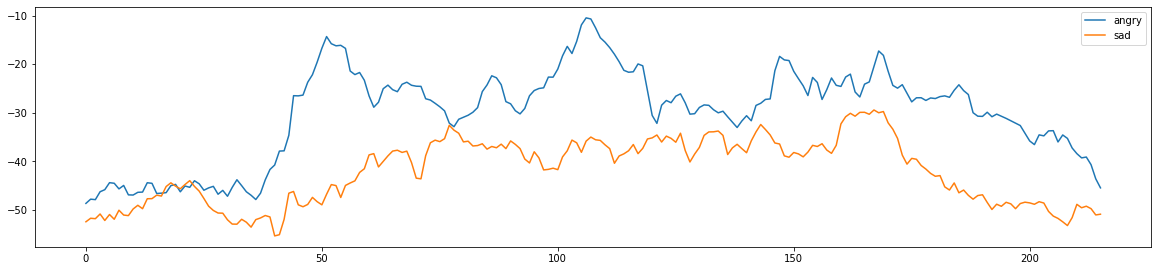

In [18]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "input/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
angry = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
angry = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(angry))
IPython.display.display(Audio(path))

# Source - RAVDESS; Gender - Female; Emotion - Sad 
path = "input/audio_speech_actors_01-24/Actor_08/03-01-04-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
sad = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
sad = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(sad))
IPython.display.display(Audio(path))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(angry, label='angry')
plt.plot(sad, label='sad')
plt.legend()

As you can see, there is a clear difference between the values for the angry and sad coefficients, we compare those when trying to tell them apart, along with the other features produced by the MFCC.

All right, let's now use a few of those features to build our model.

In [19]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [20]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [21]:
len(X), len(Y), Ravdess_df.Path.shape

(4320, 4320, (1440,))

In [22]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.300781  0.719476  0.756877  0.704359  0.687239  0.697825  0.681618   
1  0.312152  0.761725  0.817209  0.786933  0.751642  0.759208  0.727086   
2  0.185847  0.615103  0.696170  0.707124  0.653891  0.667893  0.679416   
3  0.271272  0.706568  0.717774  0.674284  0.643797  0.674999  0.653214   
4  0.319630  0.767360  0.812103  0.766090  0.731868  0.731800  0.718454   

          7         8         9  ...           153           154  \
0  0.688074  0.738104  0.763252  ...  1.705701e-06  2.192817e-06   
1  0.682109  0.728261  0.760420  ...  2.319142e-05  2.393637e-05   
2  0.669630  0.700242  0.737357  ...  3.613891e-07  4.018711e-07   
3  0.644758  0.697967  0.738217  ...  2.899537e-06  3.887445e-06   
4  0.663895  0.699426  0.729500  ...  4.245546e-05  4.555389e-05   

            155           156           157           158           159  \
0  1.764245e-06  1.249311e-06  1.170706e-06  3.010282e-06  3.577592e-06   
1  2.268723e-05  2.366349e-05  2.331000e-05  2.564844e-05  2.584022e-05   
2  4.316981e-07  4.444244e-07  2.567170e-07  2.240328e-07  5.476195e-07   
3  3.357019e-06  3.420333e-06  3.707524e-06  5.742556e-06  4.663094e-06   
4  4.480413e-05  4.493964e-05  4.576075e-05  4.692894e-05  4.636430e-05   

            160           161   labels  
0  1.764929e-06  2.393211e-07  neutral  
1  2.231149e-05  2.216732e-05  neutral  
2  4.309582e-07  3.961514e-08  neutral  
3  2.524959e-06  2.362683e-07  neutral  
4  4.443556e-05  4.146476e-05  neutral  

[5 rows x 163 columns]

## Data Preparation

Now that the data is extracted we need to normalize and split our data for training and testing


In [23]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [24]:
# As this is a multiclass classification problem so we need to onehotencode our labels.
# (Create a vector with 1 ones and zeros for each class)
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [25]:
# split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [26]:
# scale our data to have a range between 0 and 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [27]:
# Change the number of dimentions of the matrices to make them fit the model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Model creation

In [28]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [29]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 26s 67ms/step - loss: 2.0049 - accuracy: 0.1926 - val_loss: 1.9081 - val_accuracy: 0.2657
Epoch 2/50
51/51 [==============================] - 1s 19ms/step - loss: 1.9316 - accuracy: 0.2275 - val_loss: 1.8426 - val_accuracy: 0.3176
Epoch 3/50
51/51 [==============================] - 1s 20ms/step - loss: 1.8781 - accuracy: 0.2664 - val_loss: 1.7561 - val_accuracy: 0.3407
Epoch 4/50
51/51 [==============================] - 1s 19ms/step - loss: 1.8343 - accuracy: 0.2932 - val_loss: 1.7019 - val_accuracy: 0.3759
Epoch 5/50
51/51 [==============================] - 1s 18ms/step - loss: 1.7779 - accuracy: 0.3176 - val_loss: 1.6433 - val_accuracy: 0.4102
Epoch 6/50
51/51 [==============================] - 1s 19ms/step - loss: 1.7498 - accuracy: 0.3238 - val_loss: 1.5934 - val_accuracy: 0.4213
Epoch 7/50
51/51 [==============================] - 1s 18ms/step - loss: 1.6899 - accuracy: 0.3410 - val_loss: 1.5540 - val_accuracy: 0.4213
Epoch 8/50
5

34/34 [==============================] - 1s 17ms/step - loss: 1.2308 - accuracy: 0.6833
Accuracy of our model on test data :  68.33333373069763 %


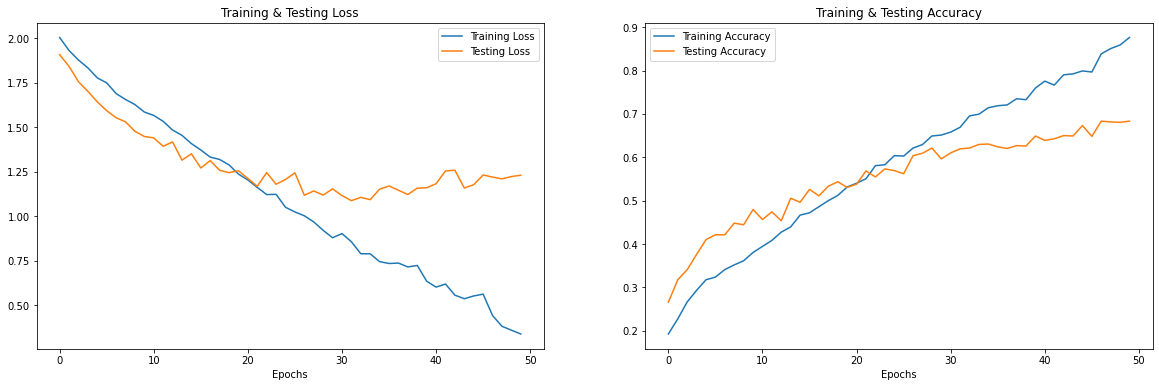

In [30]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [32]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1          disgust         angry
2             fear          fear
3          neutral          calm
4            angry         angry
5         surprise      surprise
6             fear          fear
7          disgust         happy
8             fear          fear
9          neutral           sad

Ok, let's see it in action and try to detect the anger in that an example track.

In [33]:
# Pick an angry track
fname = "input/audio_speech_actors_01-24/Actor_08/03-01-05-02-01-02-08.wav"

result = get_features(fname)

In [34]:
result.shape

(3, 162)

In [35]:
# result = np.expand_dims(result, axis=0)
# final_scaler = StandardScaler()
final_result = scaler.transform(result)
final_result = np.expand_dims(final_result, axis=2)

In [42]:
final_pred = model.predict(final_result)
print(np.around(final_pred[0], 3))

final_pred = encoder.inverse_transform(final_pred)
print(final_pred[0][0])
# Play the audio
Audio(fname)    


[1. 0. 0. 0. 0. 0. 0. 0.]
angry
